## Weather stations data

In [133]:
weather_stations = pd.read_csv("datasets/weather_stations.csv")
weather_stations.head()

STN  LON(east)  LAT(north)  ALT(m)           NAME
0  209      4.518      52.465     0.0         IJmond
1  210      4.430      52.171    -0.2  Valkenburg Zh
2  215      4.437      52.141    -1.1    Voorschoten
3  225      4.555      52.463     4.4       IJmuiden
4  235      4.781      52.928     1.2        De Kooy

In [134]:
weather_stations.shape

(50, 5)

In [135]:
weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STN         50 non-null     int64  
 1   LON(east)   50 non-null     float64
 2   LAT(north)  50 non-null     float64
 3   ALT(m)      50 non-null     float64
 4   NAME        50 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


We can see that the datatypes seem to correspong to what is expected for each column.

In [136]:
weather_stations.isna().sum()

STN           0
LON(east)     0
LAT(north)    0
ALT(m)        0
NAME          0
dtype: int64

There seem to be no NAs in our data. Next, we should check the ranges and see if they fall in realistic categories.

In [137]:
weather_stations.describe()

STN  LON(east)  LAT(north)     ALT(m)
count   50.000000  50.000000   50.000000   50.00000
mean   295.240000   5.034120   52.155380    8.79000
std     47.221821   0.996242    0.675282   18.89544
min    209.000000   3.242000   50.906000   -4.30000
25%    261.250000   4.320250   51.536750    0.00000
50%    285.500000   4.957500   52.084500    1.30000
75%    328.500000   5.759500   52.641500   11.62500
max    391.000000   7.150000   53.575000  114.30000

At a first glance, the values look normal. The points as latitude and longitude seem to mostly fit in the Netherlands borders. As noted after research, Netherlands coresponds to the coordinates of ~53.51 LAT(north) and ~3.36 LON(east). We can have a look at approximate maximum and minimum:

* MAX LON : ~7.22 LON(east) 
* MAX LAT : ~53.51 LAT(north)
* MIN LON : ~3.36 LON(east)
* MIN LAT : ~50.75 LAT(north)

As specified, these seem to fit quite well in the ranges, with very slight, insignificant differences. We can, however, continue with our analysis. Later on, we will look into altitude as well.

We can have a look at the map, with each station's positioning. This would not only confirm, once again, the accuracy of the positions, but also give us an idea and overview of the exact positioning of each on the map.

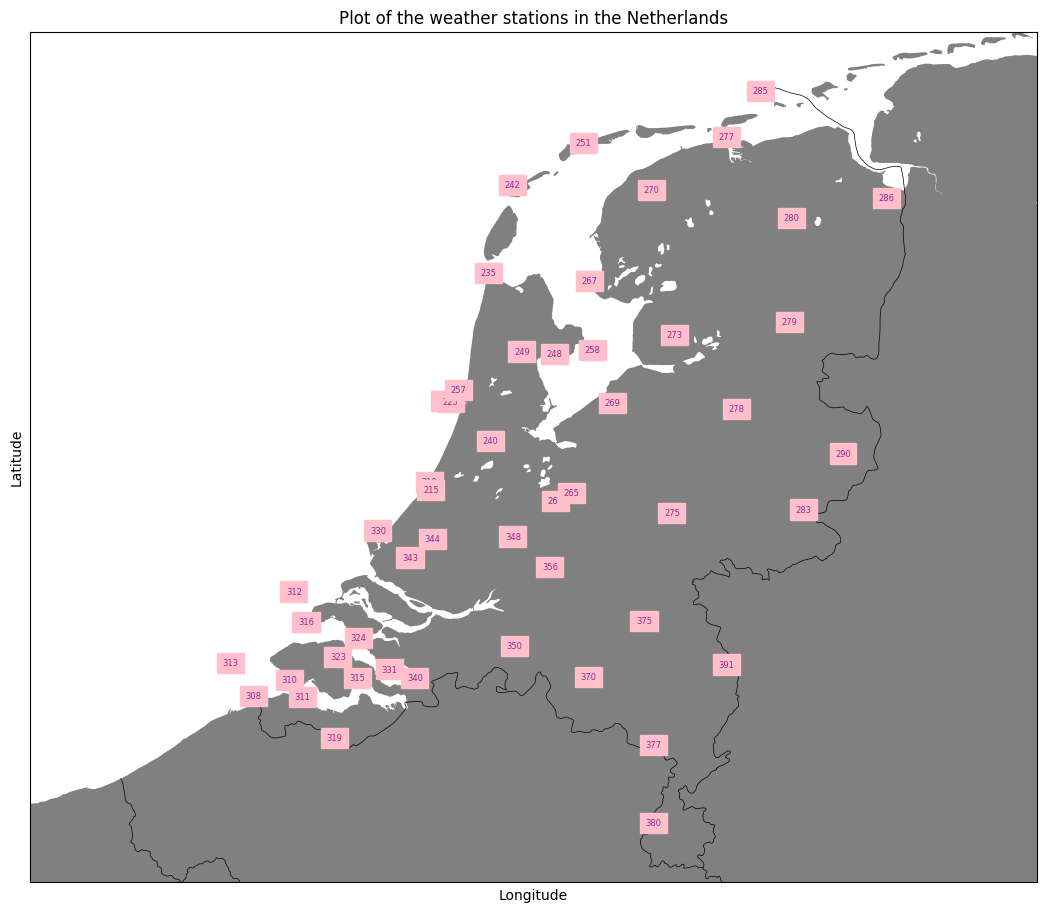

In [138]:
import numpy as np
from matplotlib import pyplot as plt


plt.figure(figsize=(13, 12))

map = Basemap(projection='merc', 
              resolution='f', 
              llcrnrlat=50.7, urcrnrlat=53.8, 
              llcrnrlon=2, urcrnrlon=8, 
              lat_ts=51)
# Plot map
map.drawcountries()
map.fillcontinents(color='grey', zorder=0)

# Plot weather station points with values as labels
x, y = map(weather_stations['LON(east)'], weather_stations['LAT(north)'])
for i in range(len(x)):
    # Adjust label placement and font size, offset labels, and use transparent background
    plt.text(x[i], y[i], f'{weather_stations["STN"][i]}', ha='right', va='bottom', fontsize=6, color='purple', backgroundcolor='pink', alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of the weather stations in the Netherlands')

plt.show()

We can now check the distribution of the altitudes.

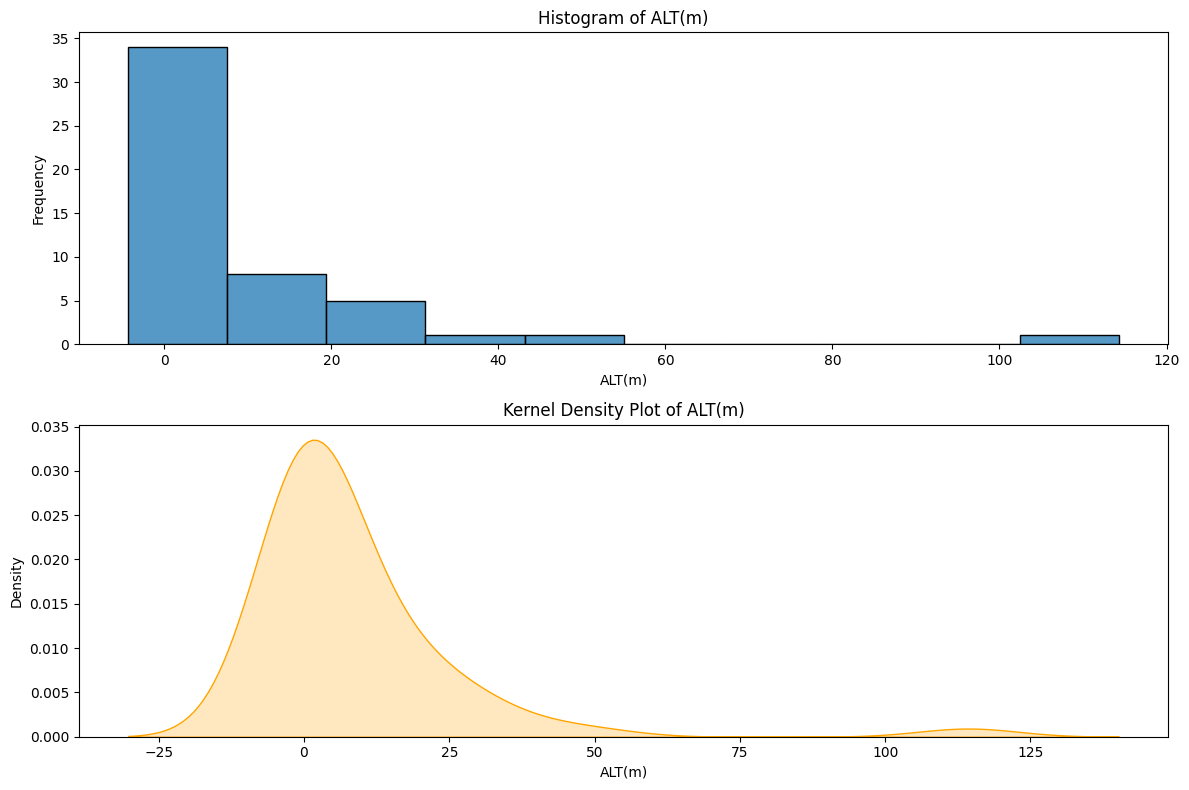

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

altitudes = weather_stations['ALT(m)']

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.histplot(altitudes, ax=axes[0], bins=10, kde=False)  #histogram
axes[0].set_title('Histogram of ALT(m)')
axes[0].set_xlabel('ALT(m)')
axes[0].set_ylabel('Frequency')
sns.kdeplot(altitudes, ax=axes[1], color='orange', fill=True) #kernel density plot
axes[1].set_title('Kernel Density Plot of ALT(m)')
axes[1].set_xlabel('ALT(m)')
axes[1].set_ylabel('Density')
plt.tight_layout()
plt.show()

We can see that most weather stations are at an altitude of around 0 and slightly larger, which is expected from a country that does not have any mountains. There seems to be an outlier station, that is situated at a much higher altitude than the others. Let's see where that actually is and if it makes sense.

In [140]:
weather_stations[weather_stations['ALT(m)'] == max(altitudes)]

STN  LON(east)  LAT(north)  ALT(m)        NAME
48  380      5.762      50.906   114.3  Maastricht

We can see this is situated in Maastricht. When we look it up online, we can see the value is accurate and the station and its coordinates actually exists. Therefore, we can state that it is reliable and consider it correct. Similarly, we can check the lowest altitude we have in our dataset, to see if it is accurate.

![Screenshot 2024-04-09 205409.png](<attachment:Screenshot 2024-04-09 205409.png>)

In [141]:
weather_stations[weather_stations['ALT(m)'] == min(altitudes)]

STN  LON(east)  LAT(north)  ALT(m)       NAME
41  344      4.447      51.962    -4.3  Rotterdam

This one seems to be located in Rotterdam. Since it is a harbour city, it makes sense that we have, in these kind of cities, stations under sea level. 

It might be relevant that we consider only data from weather stations that are close to the cities of interest. Initially, we tried considering the closest 3 stations to each city that our customer needs to travel to. However, due to large number of data, we were forced to reduce it to only one weather station per city. Below, I calculate the exact distance, in km, from the closest weather station for each city, as well as the number of the specific station.

In [142]:
from geopy.distance import geodesic

# Coordinates of Hertogenbosch, Sittard, and Boxmeer
cities = {
    'Hertogenbosch': (51.6978, 5.3037),
    'Sittard': (50.9989, 5.866),
    'Boxmeer': (51.6444, 5.9473)
}

# Function to calculate distance between two points using geopy
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Calculate distances for each city and sort weather stations based on distance
closest_stations = {}
for city, city_coords in cities.items():
    distances = {}
    for index, row in weather_stations.iterrows():
        station_coords = (row['LAT(north)'], row['LON(east)'])
        station_id = row['STN']
        distance = calculate_distance(city_coords, station_coords)
        distances[station_id] = distance
    closest_stations[city] = sorted(distances.items(), key=lambda x: x[1])[:2]

# Print the closest weather stations for each city
for city, stations in closest_stations.items():
    print(f"Closest weather stations to {city}:")
    for station_id, distance in stations:
        print(f"Station ID: {station_id}, Distance: {distance:.2f} km")
    print()

Closest weather stations to Hertogenbosch:
Station ID: 356, Distance: 20.98 km
Station ID: 370, Distance: 27.93 km

Closest weather stations to Sittard:
Station ID: 380, Distance: 12.66 km
Station ID: 377, Distance: 23.30 km

Closest weather stations to Boxmeer:
Station ID: 375, Distance: 16.71 km
Station ID: 391, Distance: 23.77 km



# Data preparation for joining

As we want to join based on only the closest weather station to each city of interest, we store these stations' names in a variable, that we later use to filter the weather data to only display records that are coming from these 3 stations of interest. 

In [143]:
unique_ids = set(id_ for station_list in closest_stations.values() for id_, _ in station_list)
unique_ids

{356, 370, 375, 377, 380, 391}

In [144]:
filtered_weather_data = df[df['Station ID'].isin(unique_ids)]
filtered_weather_data

Date (YYYY-MM-DD)  Station ID  Hour  Hourly Average Wind Speed (m/s)  \
0               1951-01-01         380    23                             98.0   
73              1951-01-01         380     4                             77.0   
74              1951-01-01         380     3                             72.0   
75              1951-01-01         380     2                             77.0   
76              1951-01-01         380     1                             82.0   
...                    ...         ...   ...                              ...   
19188527        2024-03-25         375    10                             30.0   
19188528        2024-03-25         375     8                             20.0   
19188534        2024-03-25         375     9                             30.0   
19188639        2024-03-25         380     4                             30.0   
19188674        2024-03-25         375     5                             20.0   

          Wind Speed (m/s)  Highest Wind Gust (m/s)   Temperature (0.1°C)  \
0                      0.0                 90.158365                 22.0   
73                    87.0                 89.319639                 18.0   
74                    72.0                 89.262892                 11.0   
75                     0.0                 89.261606                  0.0   
76                     0.0                 89.371168                  0.0   
...                    ...                       ...                  ...   
19188527              20.0                 50.000000                 85.0   
19188528              20.0                 30.000000                 62.0   
19188534              30.0                 40.000000                 79.0   
19188639              30.0                 30.000000                 11.0   
19188674              20.0                 30.000000                 -4.0   

          Duration of Precipitation (hours)  Precipitation Amount (mm)  \
0                                       0.0                    0.83167   
73                                      0.0                    0.83167   
74                                      0.0                    0.83167   
75                                      0.0                    0.83167   
76                                      0.0                    0.83167   
...                                     ...                        ...   
19188527                                0.0                    0.00000   
19188528                                0.0                    0.00000   
19188534                                0.0                    0.00000   
19188639                                0.0                    0.00000   
19188674                                0.0                    0.00000   

          Visibility (m)  Fog Indicator  Rainfall Indicator  Snow Indicator  \
0              53.267449            0.0                 0.0             0.0   
73             50.858531            0.0                 0.0             0.0   
74             51.162157            0.0                 0.0             0.0   
75             51.603766            0.0                 0.0             0.0   
76             52.037477            0.0                 0.0             0.0   
...                  ...            ...                 ...             ...   
19188527       66.000000            0.0                 0.0             0.0   
19188528       62.000000            0.0                 0.0             0.0   
19188534       65.000000            0.0                 0.0             0.0   
19188639       65.000000            0.0                 0.0             0.0   
19188674       56.000000            0.0                 0.0             0.0   

          Thunderstorm Indicator  Ice Formation Indicator  Month  Season  \
0                            0.0                      0.0      1  Winter   
73                           0.0                      0.0      1  Winter   
74                           0.0             

To join later on date and hour, we want to make a new column containing only the hour of the traffic jam start.

In [145]:
traffic_jam['Hour'] = traffic_jam['StartTime'].apply(lambda x: x.split(':')[0]).astype(int)
traffic_jam

TrafficJamNum  StartDate    EndDate StartTime   EndTime  Severity  \
0             3589057 2023-06-13 2023-06-13  16:54:29  17:00:06    13.480   
1             3589058 2023-06-13 2023-06-13  16:54:29  17:09:01    46.287   
2             3589060 2023-06-13 2023-06-13  16:54:29  16:56:05     5.120   
3             3589061 2023-06-13 2023-06-13  16:54:29  17:06:00    29.525   
4             3589062 2023-06-13 2023-06-13  16:54:29  17:04:00    28.952   
...               ...        ...        ...       ...       ...       ...   
1581776       2756774 2020-04-10 2020-04-10   6:31:00   7:14:41   102.150   
1581777       2756818 2020-04-10 2020-04-10  16:46:00  17:35:32   139.217   
1581778       2756726 2020-04-09 2020-04-09  14:14:00  14:17:40     7.333   
1581779       2756735 2020-04-09 2020-04-09  16:03:00  16:15:27    25.900   
1581780       2756909 2020-04-13 2020-04-13  16:40:00  17:41:19   122.633   

           Length  Duration  HectometerStart  HectometerEnd  ...  \
0        2400.000     5.617             45.6           47.9  ...   
1        3185.000    14.533             31.4           28.2  ...   
2        3200.000     1.600            166.5          169.7  ...   
3        2564.000    11.517             82.8           85.6  ...   
4        3042.000     9.517            144.3          140.6  ...   
...           ...       ...              ...            ...  ...   
1581776  2338.421    43.683             52.3           50.3  ...   
1581777  2810.565    49.533            146.2          144.2  ...   
1581778  2000.000     3.667             30.0           32.0  ...   
1581779  2080.321    12.450             51.5           53.5  ...   
1581780  2000.000    61.317            111.6          113.6  ...   

                                                CauseClass  \
0                  [Geen oorzaakcode opgegeven door VWM 6]   
1                 [Geen oorzaakcode opgegeven door VWM 15]   
2                  [Geen oorzaakcode opgegeven door VWM 2]   
3                 [Geen oorzaakcode opgegeven door VWM 12]   
4                 [Geen oorzaakcode opgegeven door VWM 10]   
...                                                    ...   
1581776  [Geen oorzaakcode opgegeven door VWM 1], [Opru...   
1581777  [Opruimingswerkzaamheden 46], [Eerder(e) ongev...   
1581778  [Geen oorzaakcode opgegeven door VWM 1], [Te h...   
1581779           [Geen oorzaakcode opgegeven door VWM 12]   
1581780  [Geen oorzaakcode opgegeven door VWM 1], [Onge...   

              CauseCodeClass CauseCode  \
0                      [000]       001   
1                      [000]       001   
2                      [000]       001   
3                      [000]       001   
4                      [000]       001   
...                      ...       ...   
1581776         [000], [CLE]       CLE   
1581777         [OCL], [ACA]       ACI   
1581778  [000], [OHW], [000]       OHW   
1581779                [000]       001   
1581780         [000], [ACI]       ACI   

                                                  Cause_1  \
0                         Spitsfile (geen oorzaak gemeld)   
1                         Spitsfile (geen oorzaak gemeld)   
2                         Spitsfile (geen oorzaak gemeld)   
3                         Spitsfile (geen oorzaak gemeld)   
4                         Spitsfile (geen oorzaak gemeld)   
...                                                   ...   
1581776                               Opruimwerkzaamheden   
1581777                                      Ongeval(len)   
1581778  Te hoog voertuig gesignaleerd, wordt afgehandeld   
1581779                   Spitsfile (geen oorzaak gemeld)   
1581780                                      Ongeval(len)   

                     Cause_2                         Cause_3  \
0        Geen oorzaak gemeld                          Drukte   
1        Geen oorzaak gemeld                          Drukte   
2        Geen oorzaak gemeld                          Drukte   
3        Geen oorzaak gemel

To get an overview of the times when most traffic jams happen, we can create a line/bar chart.

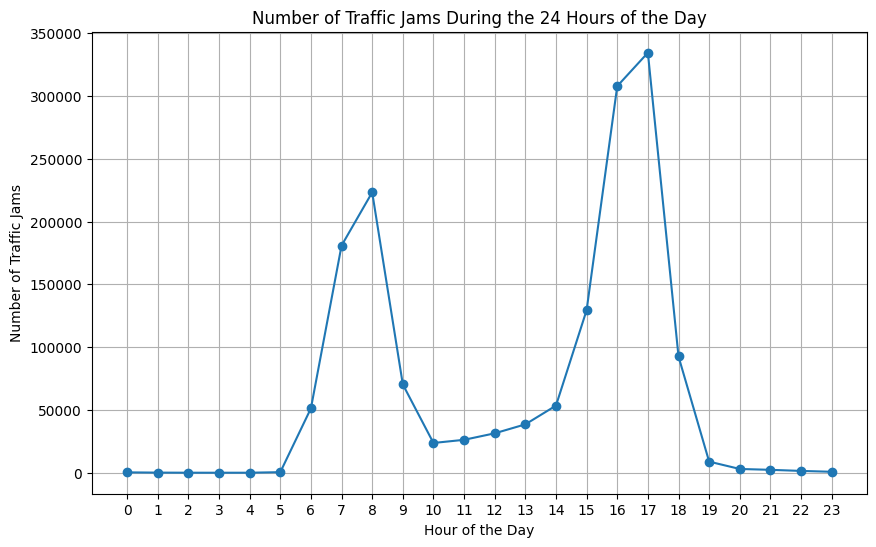

In [146]:
hourly_counts = traffic_jam['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Traffic Jams')
plt.title('Number of Traffic Jams During the 24 Hours of the Day')
plt.xticks(range(0, 24)) # Ensure all hours are shown on the x-axis
plt.grid(True)
plt.show()

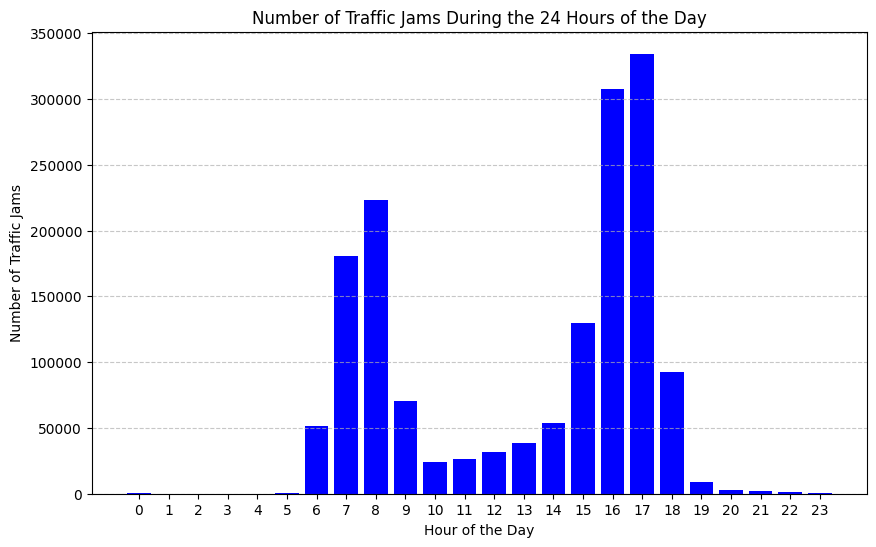

In [147]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Traffic Jams')
plt.title('Number of Traffic Jams During the 24 Hours of the Day')
plt.xticks(range(0, 24)) # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As expected, it seems that most traffic jams happen during the morning, mainly between 7 and 9, as well as at the end of the workday, approximately from 16 to 18. This matches perfectly with the 9 to 17 schedule most people work by.

#### A2 and A73 

As we want to only have the specific roads that our client can possibly use to reach the offices, we will prepare the data for joining by filtering on the roads A2 and A73.

In [148]:
filtered_traffic= traffic_jam[(traffic_jam['RoadDescr'] == 'A73') | (traffic_jam['RoadDescr'] == 'A2')]
filtered_traffic


TrafficJamNum  StartDate    EndDate StartTime   EndTime  Severity  \
7             3589149 2023-06-13 2023-06-13  17:03:29  17:17:00    32.867   
41            3589794 2023-06-13 2023-06-13  18:37:28  18:43:00    16.465   
61            3590025 2023-06-14 2023-06-14   7:12:25   7:25:02    41.488   
66            3590065 2023-06-14 2023-06-14   7:25:25   8:07:00   216.928   
74            3590164 2023-06-14 2023-06-14   7:49:26   7:51:00     3.447   
...               ...        ...        ...       ...       ...       ...   
1581684       2757675 2020-04-23 2020-04-23  12:12:00  12:32:56    57.350   
1581715       2757792 2020-04-24 2020-04-24  13:35:00  13:45:06    20.200   
1581760       2756631 2020-04-08 2020-04-08  12:58:00  15:06:07   405.883   
1581765       2756680 2020-04-09 2020-04-09   6:25:00   6:31:41    13.367   
1581772       2756682 2020-04-09 2020-04-09   6:31:00   7:02:04    62.200   

           Length  Duration  HectometerStart  HectometerEnd  ...  \
7        2432.000    13.517            115.9          118.1  ...   
41       2976.000     5.533             92.0           89.5  ...   
61       3288.000    12.617             43.8           41.4  ...   
66       5217.000    41.583             44.2           40.0  ...   
74       2200.000     1.567            105.5          103.3  ...   
...           ...       ...              ...            ...  ...   
1581684  2739.650    20.933            162.3          164.3  ...   
1581715  2000.000    10.100            219.2          221.2  ...   
1581760  3168.076   128.117             90.6           92.6  ...   
1581765  2000.000     6.683             68.9           70.9  ...   
1581772  2002.146    31.067             69.1           71.1  ...   

                                                CauseClass  \
7                 [Geen oorzaakcode opgegeven door VWM 14]   
41                 [Geen oorzaakcode opgegeven door VWM 6]   
61                [Geen oorzaakcode opgegeven door VWM 13]   
66                [Geen oorzaakcode opgegeven door VWM 42]   
74                 [Geen oorzaakcode opgegeven door VWM 2]   
...                                                    ...   
1581684  [Geen oorzaakcode opgegeven door VWM 1], [Defe...   
1581715  [Geen oorzaakcode opgegeven door VWM 1], [Onge...   
1581760  [Geen oorzaakcode opgegeven door VWM 3], [Opru...   
1581765       [Ongeval(len) 5], [Eerder(e) ongeval(len) 2]   
1581772  [Geen oorzaakcode opgegeven door VWM 1], [Eerd...   

                     CauseCodeClass CauseCode  \
7                             [000]       001   
41                            [000]       001   
61                            [000]       001   
66                            [000]       001   
74                            [000]       001   
...                             ...       ...   
1581684         [000], [BKD], [000]       BKD   
1581715         [000], [ACI], [000]       ACI   
1581760  [000], [OCL], [HBD], [OCL]       HBD   
1581765                [ACI], [ACA]       ACI   
1581772                [000], [ACA]       ACA   

                                 Cause_1              Cause_2  \
7        Spitsfile (geen oorzaak gemeld)  Geen oorzaak gemeld   
41       Spitsfile (geen oorzaak gemeld)  Geen oorzaak gemeld   
61       Spitsfile (geen oorzaak gemeld)  Geen oorzaak gemeld   
66       Spitsfile (geen oorzaak gemeld)  Geen oorzaak gemeld   
74       Spitsfile (geen oorzaak gemeld)  Geen oorzaak gemeld   
...                                  ...                  ...   
1581684           Defect(e) voertuig(en)      Defect voertuig   
1581715                     Ongeval(len)              Ongeval   
1581760           Defecte vrachtwagen(s)  Defecte vrachtwagen   
1581765                     Ongeval(len)              Ongeval   
1581772           Eerder(e) ongeval(len)              Ongeval   

                              Cause_3           Cause_4       StartDateTime  \
7                              Drukte  Hoge intensiteit 2023-06-13 17:03

# Data joining

First, we join the weather data with the stations data, so we can have now the details of the stations and the daily weather values in one table.

In [149]:
merged_weather_data = pd.merge(weather_stations, filtered_weather_data, left_on='STN', right_on='Station ID')
merged_weather_data

STN  LON(east)  LAT(north)  ALT(m)       NAME Date (YYYY-MM-DD)  \
0        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
1        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
2        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
3        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
4        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
...      ...        ...         ...     ...        ...               ...   
2731026  391      6.197      51.498    19.5      Arcen        2024-03-25   
2731027  391      6.197      51.498    19.5      Arcen        2024-03-25   
2731028  391      6.197      51.498    19.5      Arcen        2024-03-25   
2731029  391      6.197      51.498    19.5      Arcen        2024-03-25   
2731030  391      6.197      51.498    19.5      Arcen        2024-03-25   

         Station ID  Hour  Hourly Average Wind Speed (m/s)  Wind Speed (m/s)  \
0               356    24                        48.592240         47.575092   
1               356    23                        48.703325         47.523316   
2               356    22                        48.827219         47.667645   
3               356    21                        48.860701         47.708713   
4               356    20                        26.000000         26.000000   
...             ...   ...                              ...               ...   
2731026         391     4                        20.000000         10.000000   
2731027         391     3                        20.000000         20.000000   
2731028         391     2                        20.000000         20.000000   
2731029         391     1                        20.000000         20.000000   
2731030         391     6                        10.000000         20.000000   

         ...  Precipitation Amount (mm)  Visibility (m)  Fog Indicator  \
0        ...                    0.83167       52.772276            0.0   
1        ...                    0.83167       53.439274            0.0   
2        ...                    0.83167       53.990515            0.0   
3        ...                    0.83167       54.586565            0.0   
4        ...                    0.83167       55.201124            0.0   
...      ...                        ...             ...            ...   
2731026  ...                    0.00000       52.941793            0.0   
2731027  ...                    0.00000       54.311324            0.0   
2731028  ...                    0.00000       55.889735            0.0   
2731029  ...                    0.00000       57.121085            0.0   
2731030  ...                    0.00000       54.388482            0.0   

         Rainfall Indicator  Snow Indicator  Thunderstorm Indicator  \
0                       0.0             0.0                     0.0   
1                       0.0             0.0                     0.0   
2                       0.0             0.0                     0.0   
3                       0.0             0.0                     0.0   
4                       0.0             0.0                     0.0   
...                     ...             ...                     ...   
2731026                 0.0             0.0                     0.0   
2731027                 0.0             0.0                     0.0   
2731028                 0.0             0.0                     0.0   
2731029                 0.0             0.0                     0.0   
2731030                 0.0             0.0                     0.0   

         Ice Formation Indicator  Month  Season  DOP Sector  
0                            0.0     10  Autumn           0  
1                            0.0     10  Autumn           0  
2                            0.0     10  Autumn           0  
3                            0.0     10  Autumn           0  
4                            0.0     10  Autumn           0  
...                  

Finally, we reach our (initial) final table by performing a left join on the previously created table and the traffic data we filtered. We decided to join based on both date and hour, so in this way we can keep records of all days and hours recorded by the weather stations we selected. In the future, we can try reducing this number by removing some dates that might be too far in the past to be relevant, but this is the table we will keep for now.

In [150]:
merged_data = pd.merge(merged_weather_data, filtered_traffic, left_on=['Date (YYYY-MM-DD)', 'Hour'], right_on=['StartDate', 'Hour'], how = 'left')
merged_data

STN  LON(east)  LAT(north)  ALT(m)       NAME Date (YYYY-MM-DD)  \
0        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
1        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
2        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
3        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
4        356      5.146      51.859     0.7  Herwijnen        1989-10-05   
...      ...        ...         ...     ...        ...               ...   
3757194  391      6.197      51.498    19.5      Arcen        2024-03-25   
3757195  391      6.197      51.498    19.5      Arcen        2024-03-25   
3757196  391      6.197      51.498    19.5      Arcen        2024-03-25   
3757197  391      6.197      51.498    19.5      Arcen        2024-03-25   
3757198  391      6.197      51.498    19.5      Arcen        2024-03-25   

         Station ID  Hour  Hourly Average Wind Speed (m/s)  Wind Speed (m/s)  \
0               356    24                        48.592240         47.575092   
1               356    23                        48.703325         47.523316   
2               356    22                        48.827219         47.667645   
3               356    21                        48.860701         47.708713   
4               356    20                        26.000000         26.000000   
...             ...   ...                              ...               ...   
3757194         391     4                        20.000000         10.000000   
3757195         391     3                        20.000000         20.000000   
3757196         391     2                        20.000000         20.000000   
3757197         391     1                        20.000000         20.000000   
3757198         391     6                        10.000000         20.000000   

         ...  CauseCodeDescr  CauseClass  CauseCodeClass  CauseCode  Cause_1  \
0        ...             NaN         NaN             NaN        NaN      NaN   
1        ...             NaN         NaN             NaN        NaN      NaN   
2        ...             NaN         NaN             NaN        NaN      NaN   
3        ...             NaN         NaN             NaN        NaN      NaN   
4        ...             NaN         NaN             NaN        NaN      NaN   
...      ...             ...         ...             ...        ...      ...   
3757194  ...             NaN         NaN             NaN        NaN      NaN   
3757195  ...             NaN         NaN             NaN        NaN      NaN   
3757196  ...             NaN         NaN             NaN        NaN      NaN   
3757197  ...             NaN         NaN             NaN        NaN      NaN   
3757198  ...             NaN         NaN             NaN        NaN      NaN   

         Cause_2  Cause_3  Cause_4  StartDateTime  EndDateTime  
0            NaN      NaN      NaN            NaT          NaT  
1            NaN      NaN      NaN            NaT          NaT  
2            NaN      NaN      NaN            NaT          NaT  
3            NaN      NaN      NaN            NaT          NaT  
4            NaN      NaN      NaN            NaT          NaT  
...          ...      ...      ...            ...          ...  
3757194      NaN      NaN      NaN            NaT          NaT  
3757195      NaN      NaN      NaN            NaT          NaT  
3757196      NaN      NaN      NaN            NaT          NaT  
3757197      NaN      NaN      NaN            NaT          NaT  
3757198      NaN      NaN      NaN            NaT          NaT  

[3757199 rows x 51 columns]

## EDA on (initial) final dataset 
#### For the requested weather stations and roads

We will add a new column, that displays the weekday name of each date.

In [151]:
merged_data['Date (YYYY-MM-DD)']= pd.to_datetime(merged_data['Date (YYYY-MM-DD)'])

merged_data['Weekday Name'] = merged_data['Date (YYYY-MM-DD)'].dt.day_name()

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757199 entries, 0 to 3757198
Data columns (total 52 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   STN                                int64         
 1   LON(east)                          float64       
 2   LAT(north)                         float64       
 3   ALT(m)                             float64       
 4   NAME                               object        
 5   Date (YYYY-MM-DD)                  datetime64[ns]
 6   Station ID                         int32         
 7   Hour                               int32         
 8   Hourly Average Wind Speed (m/s)    float64       
 9   Wind Speed (m/s)                   float64       
 10  Highest Wind Gust (m/s)            float64       
 11  Temperature (0.1°C)                float64       
 12  Duration of Precipitation (hours)  float64       
 13  Precipitation Amount (mm)          float64       
 14  Vi

In [152]:
unique_dates_weekdays = merged_data.drop_duplicates(subset=['Date (YYYY-MM-DD)', 'Weekday Name'])

unique_dates_weekdays['Weekday Name'].value_counts()

Weekday Name
Thursday     3821
Friday       3821
Saturday     3821
Sunday       3821
Monday       3821
Tuesday      3821
Wednesday    3821
Name: count, dtype: int64

It seems that we have a perfectly even distribution of records for each weekday. It might be interesting to see how much out of each is days with traffic jams.

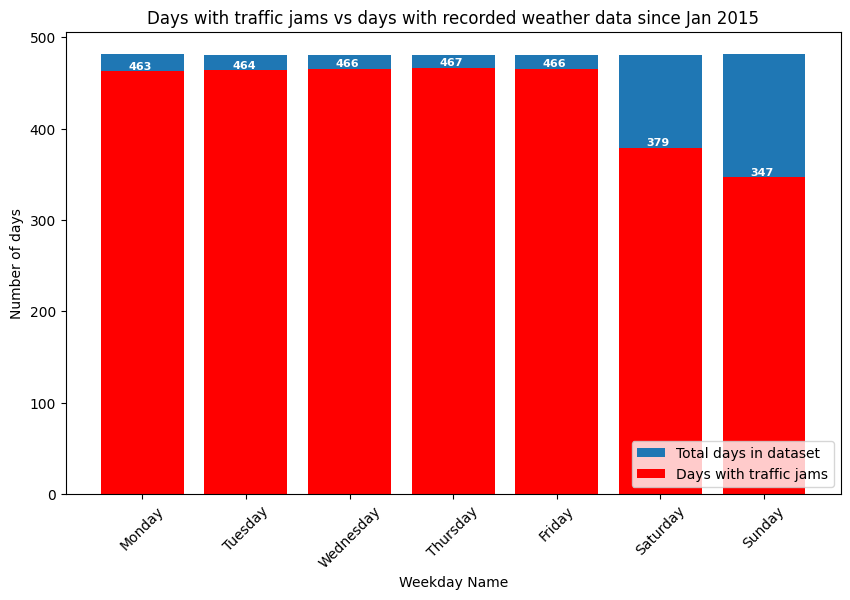

In [153]:
# Unique weekdays in the dataset with recorded weather data
unique_dates_weekdays = merged_data.drop_duplicates(subset=['Date (YYYY-MM-DD)', 'Weekday Name'])
min_date = merged_data['StartDate'].min()
unique_dates_weekdays = unique_dates_weekdays[unique_dates_weekdays['Date (YYYY-MM-DD)'] >= min_date]
value_counts = unique_dates_weekdays['Weekday Name'].value_counts()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorted_value_counts = value_counts.reindex(weekday_order)

# Unique days with traffic jams (one or more)
unique_weekdays_with_traffic = merged_data.drop_duplicates(subset=['StartDate', 'Weekday Name']) 
value_counts_traffic = unique_weekdays_with_traffic['Weekday Name'].value_counts()
sorted_value_counts_traffic = value_counts_traffic.reindex(weekday_order)

plt.figure(figsize=(10, 6))
bars1 =plt.bar(sorted_value_counts.index, sorted_value_counts.values)
bars = plt.bar(sorted_value_counts_traffic.index, sorted_value_counts_traffic.values, color = 'red')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3.0, yval, int(yval), va='bottom',fontsize=8, color='white',  fontweight='bold')

plt.xlabel('Weekday Name')
plt.ylabel('Number of days')
plt.title('Days with traffic jams vs days with recorded weather data since Jan 2015')
plt.xticks(rotation=45)
plt.legend([bars1, bars], ['Total days in dataset', 'Days with traffic jams'], loc='lower right')
plt.show()


We can see, as expected, that the weekends have significantly less traffic jams than the workdays. This could be due people not having to go to work.

Since we can see that the traffic data starts from 2015, whereas the weather data states even back to 1951, it created a huge number of NAs in our final table. We can, for the future, consider reducing the dataset to only records starting 2015.

In [154]:
print(merged_data['StartDate'].min())
print(merged_data['Date (YYYY-MM-DD)'].min())

2015-01-04 00:00:00
1951-01-01 00:00:00


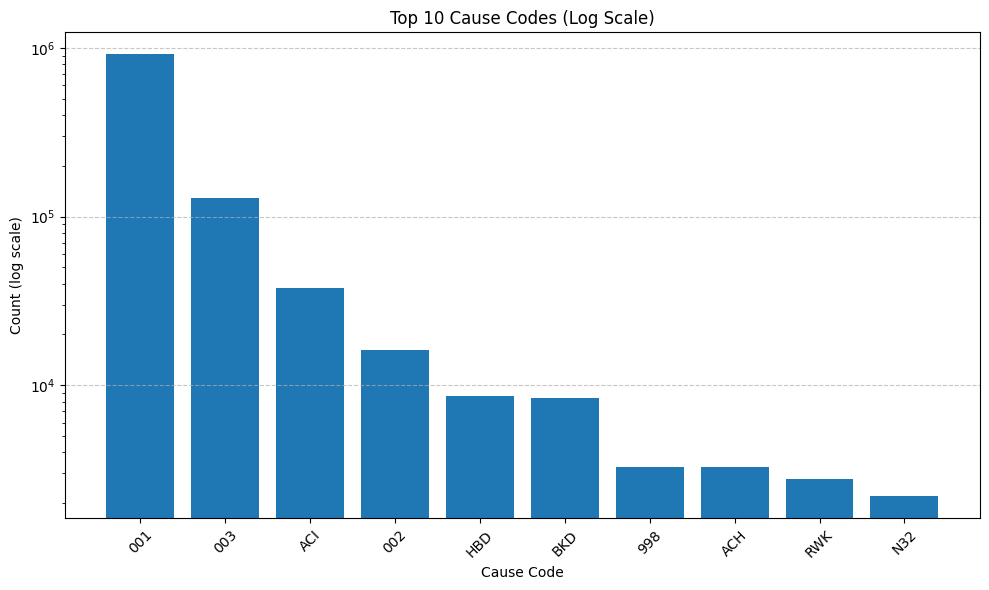

In [155]:
top_n = 10

cause_code_counts = merged_data['CauseCode'].value_counts()
#Since we see big differenc between causes, we will select the top 10
top_cause_code_counts = cause_code_counts.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_cause_code_counts.index, top_cause_code_counts)
plt.yscale('log') 
plt.title(f'Top {top_n} Cause Codes (Log Scale)')
plt.xlabel('Cause Code')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can try spotting some initial relationships between relevant variables by creating a pairplot.

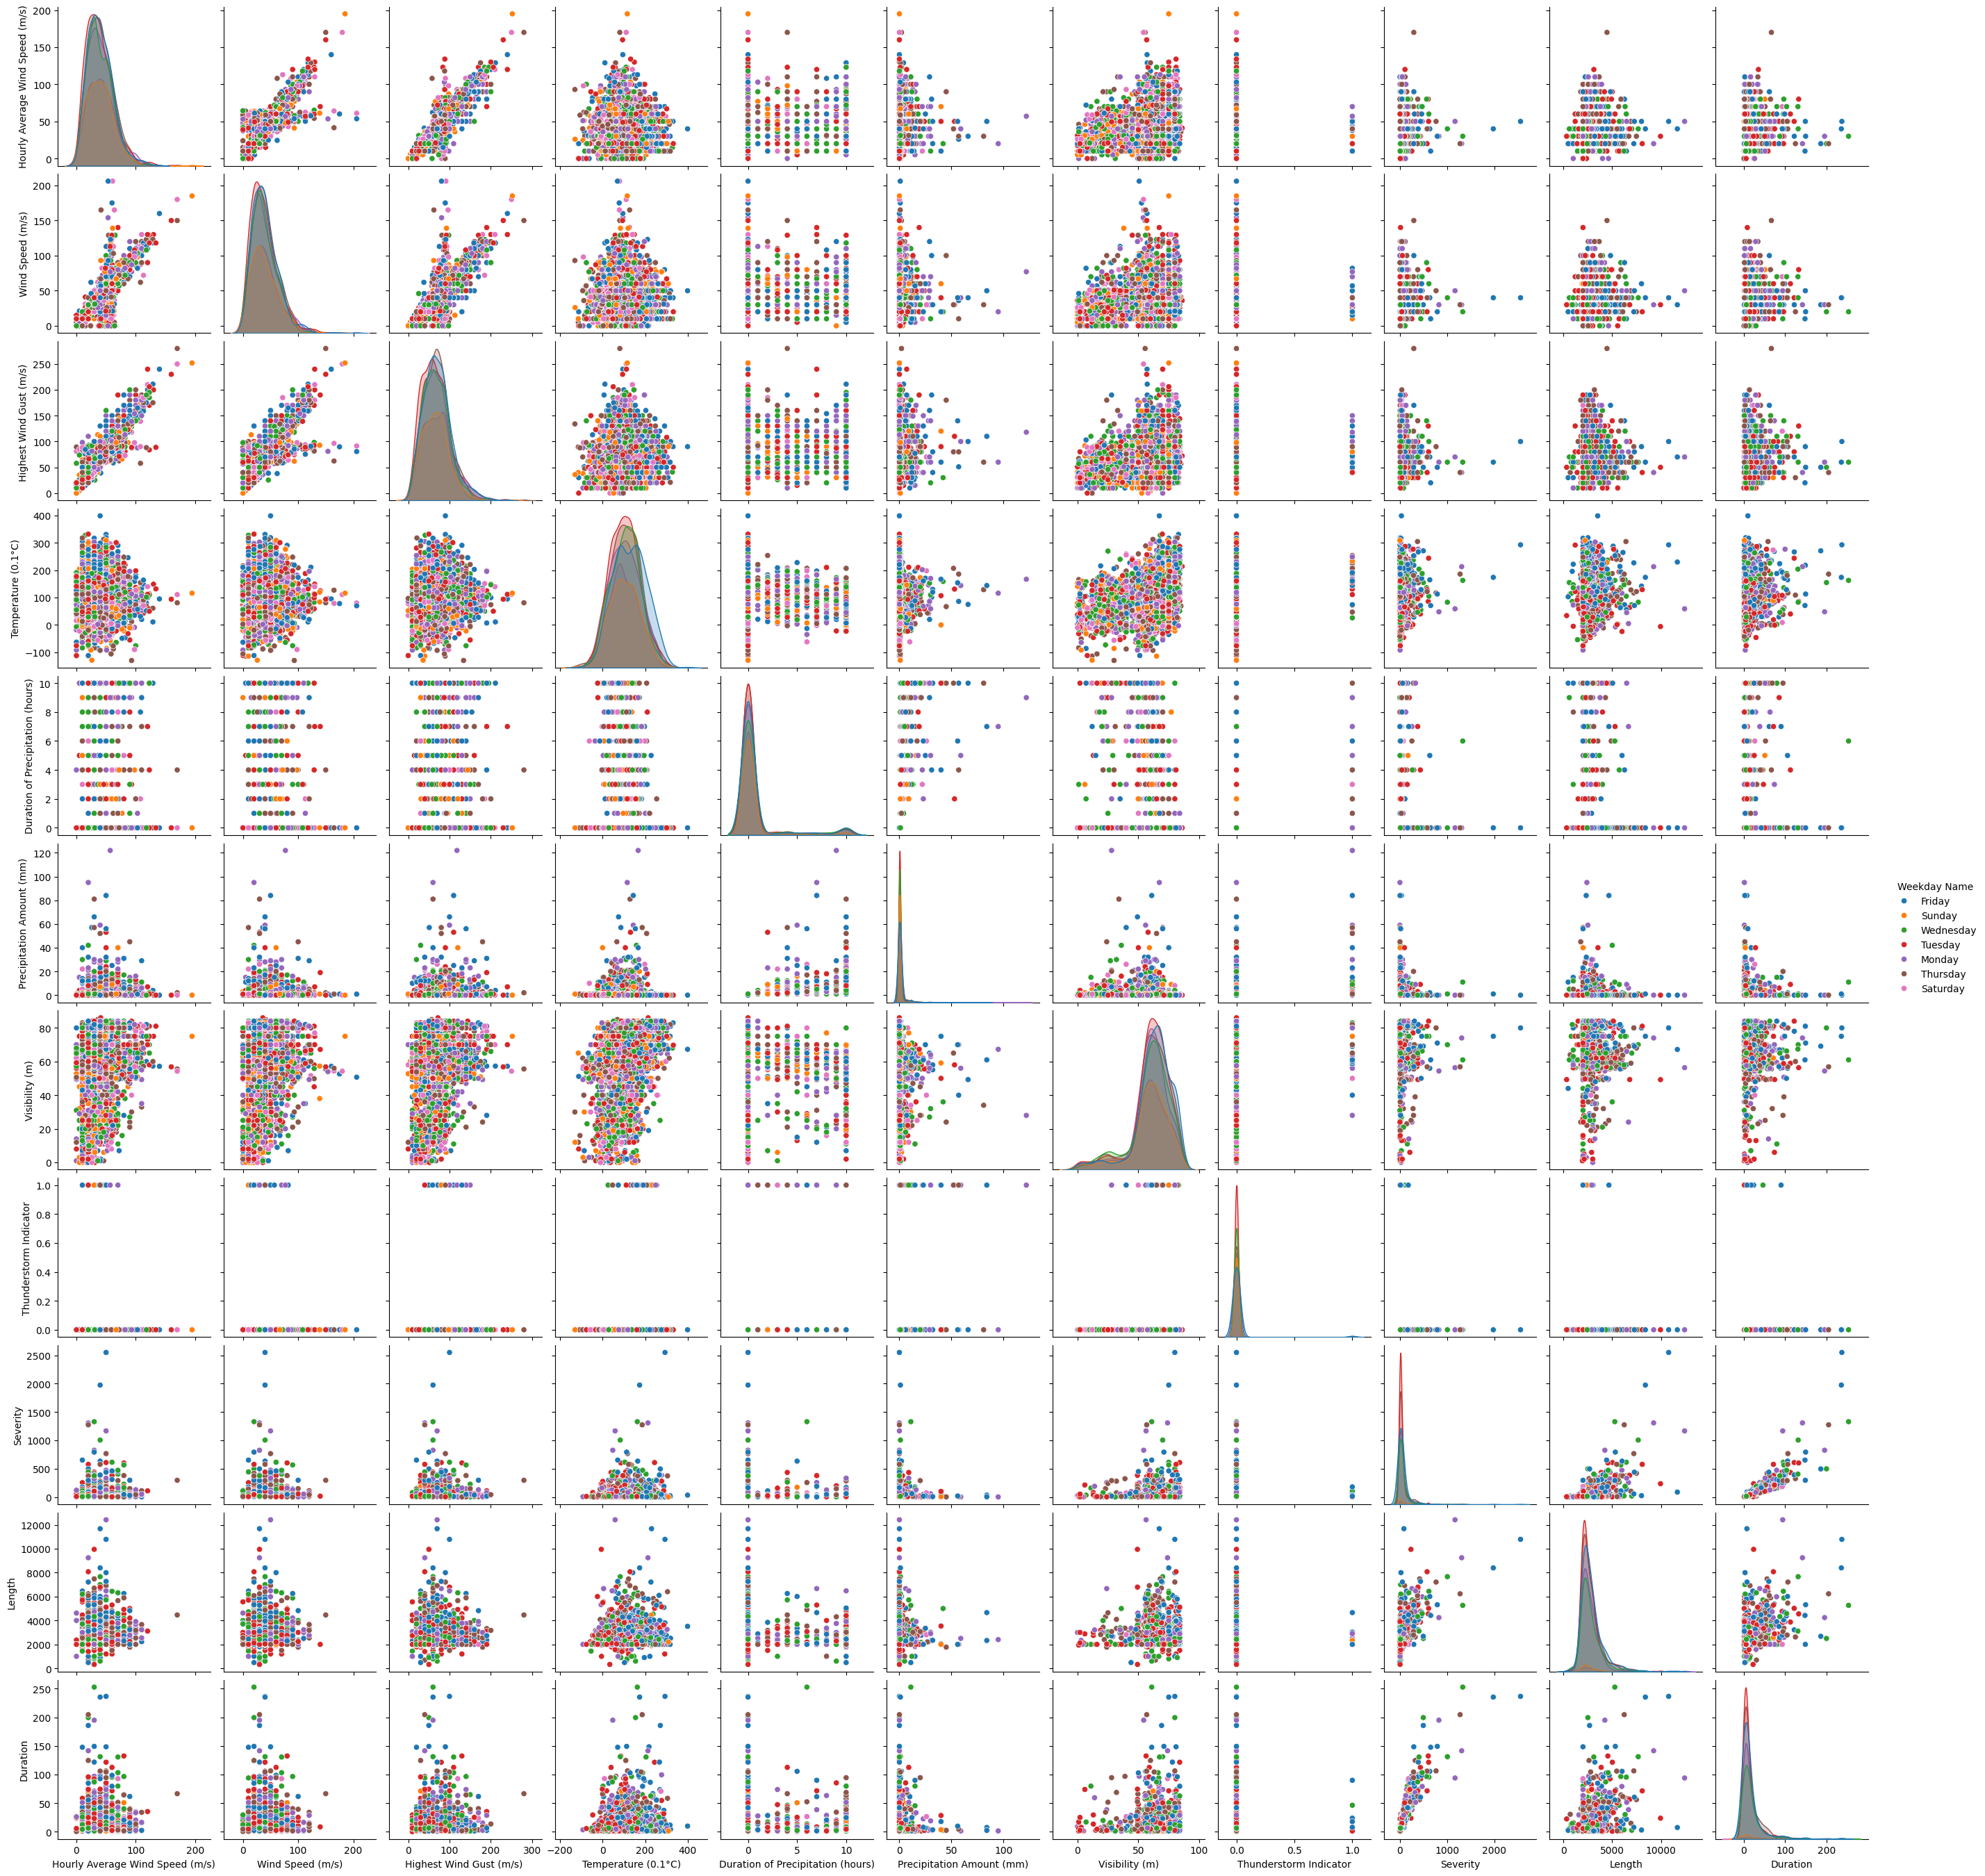

In [156]:
import seaborn as sns

columns_to_drop = ['LON(east)', 'LAT(north)', 'Rainfall Indicator', 'Snow Indicator',
       'Fog Indicator', 'Ice Formation Indicator', 'TrafficJamNum', 'RoadNumber', 'ALT(m)', 'HectometerStart', 'HectometerEnd' ]
categorical_data = merged_data.select_dtypes(exclude=['int32', 'int64'])
categorical_data = categorical_data.drop(columns=columns_to_drop)
sns.pairplot(categorical_data.sample(5000), hue="Weekday Name")

As the dataset has a lot of columns and rows, it would take to much time to try and see the results of a pairplot on all data. However, we could keep the number of relevant columns, but simply reduce the rows to a reasonable number, so that we can still spot a trend, while taking all columns into account.

We are specifically interested in **Duration of the traffic jam** and **Severity of the traffic jam**. We can observe already that these 2 form some kind of linear relationship, therefore leading us to think that the grade given for severity is heavily influenced also by duration. We can also see, for both of them, that they are somewhat displaying a linear relationship with the **Average Length**, although not as strong. 

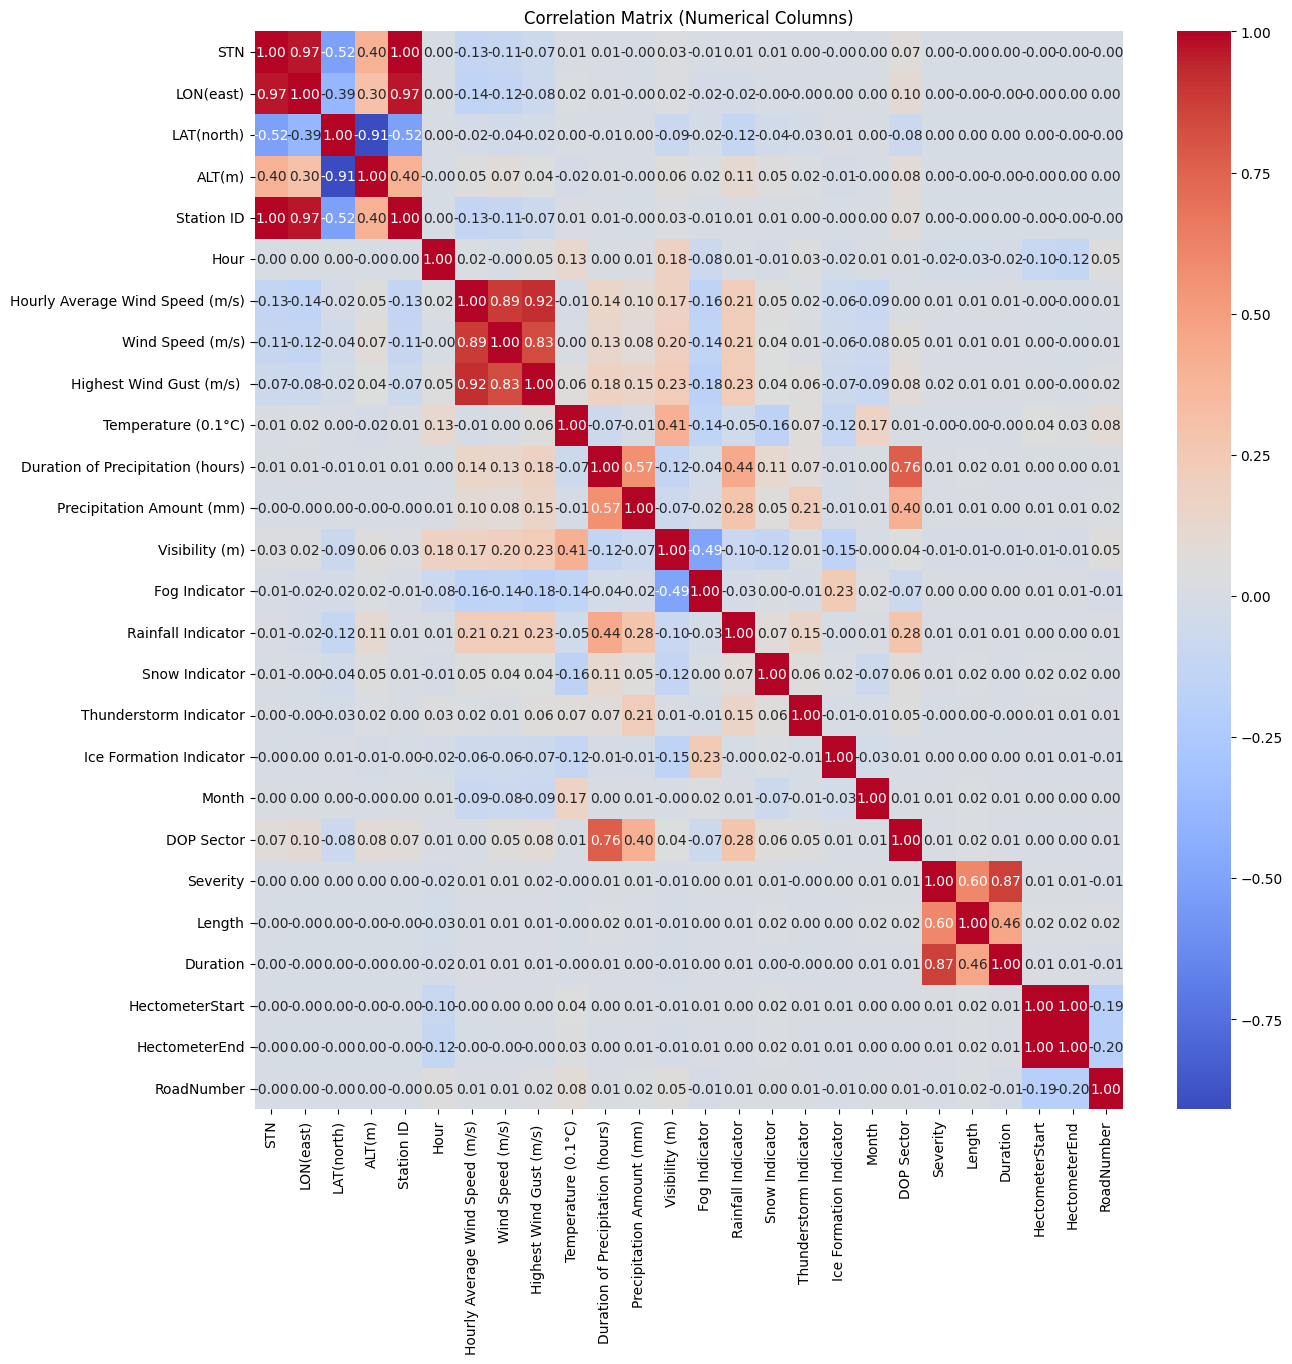

In [157]:
# Selecting only the numerical columns
numerical_columns = merged_data.select_dtypes(include=['int64', 'float64', 'int32'])

correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numerical Columns)')
plt.show()

We can not observe any relevant correlations. :-( This, however, is constant with our discoveries from the pairplot, as we can only observe the same main correlations we could also spot from the initial graphs. I am making this message to test the push-commit-pull chain. ddd